In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

E:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "copy",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1235 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Corynespora',
 'Healthy',
 'Pesta',
 'Powdery mildew',
 'birds eye',
 'colletorichum leaf disease']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 5 1 0 1 1 5 5 0 5 4 5 5 5 4 1 1 0 5 1 1 1 0 4 5 2 4 0 5 0 5 4]


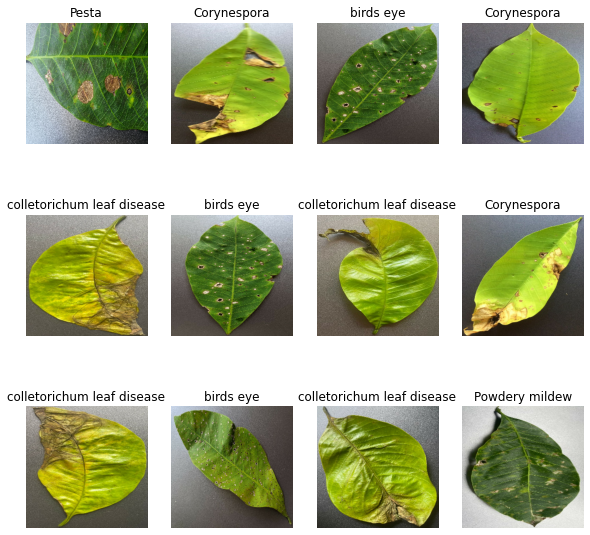

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

39

In [8]:
train_size = 0.8
len(dataset)*train_size

31.200000000000003

In [9]:
train_ds = dataset.take(31)
len(train_ds)

31

In [10]:
test_ds = dataset.skip(31)
len(test_ds)

8

In [11]:
val_size=0.1
len(dataset)*val_size

3.9000000000000004

In [12]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [13]:
test_ds = test_ds.skip(3)
len(test_ds)

5

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
import time

start_time = time.time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

end_time = time.time()

Epoch 1/10
31/31 [==============================] - 61s 2s/step - loss: 1.6345 - accuracy: 0.3216 - val_loss: 1.1913 - val_accuracy: 0.5312
Epoch 2/10
31/31 [==============================] - 53s 2s/step - loss: 1.1306 - accuracy: 0.5444 - val_loss: 0.8316 - val_accuracy: 0.6562
Epoch 3/10
31/31 [==============================] - 53s 2s/step - loss: 0.8597 - accuracy: 0.6562 - val_loss: 0.6751 - val_accuracy: 0.7812
Epoch 4/10
31/31 [==============================] - 53s 2s/step - loss: 0.6212 - accuracy: 0.7782 - val_loss: 0.3999 - val_accuracy: 0.8438
Epoch 5/10
31/31 [==============================] - 53s 2s/step - loss: 0.4310 - accuracy: 0.8518 - val_loss: 0.4728 - val_accuracy: 0.8125
Epoch 6/10
31/31 [==============================] - 60s 2s/step - loss: 0.3842 - accuracy: 0.8679 - val_loss: 0.2425 - val_accuracy: 0.9271
Epoch 7/10
31/31 [==============================] - 52s 2s/step - loss: 0.2800 - accuracy: 0.9083 - val_loss: 0.2745 - val_accuracy: 0.9062
Epoch 8/10
31/31 [==

In [23]:
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60  # Convert to minutes

print(f"Training time: {training_time_minutes:.2f} minutes")

Training time: 9.06 minutes


In [24]:
scores = model.evaluate(train_ds)

31/31 [==============================] - 8s 258ms/step - loss: 0.1860 - accuracy: 0.9365


In [25]:
scores = model.evaluate(val_ds)

3/3 [==============================] - 1s 249ms/step - loss: 0.3446 - accuracy: 0.8750


In [26]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 279ms/step - loss: 0.2503 - accuracy: 0.9125
